In [1]:
# Libraries

import os
import pandas
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.report import report_load
from source.python.report import report_concat
from source.python.report import report_filter
from source.python.report import report_plot
from source.python.io     import loader
from source.python.io     import writer
from source.python        import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# List reports folder content

PRINT_FILES = False

ROOT_DIR = os.path.join(ROOT, 'reports')
DATA_DIR = os.path.join(ROOT, 'output', 'nbp13-report')

shutil.rmtree(DATA_DIR, ignore_errors = True)
os.makedirs(DATA_DIR, exist_ok = True)

if PRINT_FILES :
	for index, name in enumerate(os.listdir(ROOT_DIR), start = 0) :
		path_l0 = os.path.join(ROOT_DIR, name)

		if index == 0 : print('{} :'.format(path_l0))
		else          : print('\n{} :'.format(path_l0))

		for name in os.listdir(path_l0) :
			print('...\\{}'.format(name))

		print()

In [5]:
# Load existing configurations

CONFIG_DIR = os.path.join(ROOT, 'resources', 'tuner')

ZCONFIG_PATH = os.path.join(CONFIG_DIR, 'zrimec.json')
WCONFIG_PATH = os.path.join(CONFIG_DIR, 'washburn.json')

ZCONFIG = list()
WCONFIG = list()

CONFIG_MAX       = 100
CONFIG_BEST      = 10
CONFIG_OVERWRITE = True
CONFIG_EXTEND    = False

if os.path.exists(ZCONFIG_PATH) and CONFIG_EXTEND :
	ZCONFIG = loader.load_json(filename = ZCONFIG_PATH)

	print('Sucessufully loaded configuration [{:88s}] with [{:2d}] elements'.format(ZCONFIG_PATH, len(ZCONFIG)))
	print()

if os.path.exists(WCONFIG_PATH) and CONFIG_EXTEND :
	WCONFIG = loader.load_json(filename = WCONFIG_PATH)

	print('Sucessufully loader configuration [{:88s}] with [{:2d}] elements'.format(WCONFIG_PATH, len(WCONFIG)))
	print()

# 1. Tuner CNN

In [6]:
# Load tune model reports

report_tune_model = report_load.load_cnn_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 5
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\zrimec-tf2150-f2-0250-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\zrimec-tf2150-f2-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\zrimec-tf2150-f2-1000-25-72-tissue-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-tissue-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-cnn\washburn-tf2150-f2-0250-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projec

In [7]:
# Display overall regression prediction

R2_THRESHOLD = 0.00

for key, dataframe in report_tune_model['regression'].items() :
	nan_mse = dataframe['valid_loss'].isnull().values.ravel().sum()
	pos_r2  = dataframe[dataframe['valid_r2'] > R2_THRESHOLD]['valid_r2'].count()
	neg_r2  = dataframe[dataframe['valid_r2'] < R2_THRESHOLD]['valid_r2'].count()

	print('{:50s} : Size = {:4d} || NaN Loss = {:4d} || Pos R2 = {:4d} || Neg R2 = {:4d}'.format(key, len(dataframe), nan_mse, pos_r2, neg_r2))

print()

zrimec-tf2150-f2-0250-25-77-tissue-mean-explode    : Size =  250 || NaN Loss =    0 || Pos R2 =  144 || Neg R2 =  106
zrimec-tf2150-f2-1000-25-72-global-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  211 || Neg R2 =  789
zrimec-tf2150-f2-1000-25-72-tissue-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  253 || Neg R2 =  747
zrimec-tf2150-f3-1000-25-72-global-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  201 || Neg R2 =  799
zrimec-tf2150-f3-1000-25-72-tissue-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  118 || Neg R2 =  882
zrimec-tf2150-f3-1000-25-77-tissue-mean-explode    : Size =  527 || NaN Loss =    0 || Pos R2 =  107 || Neg R2 =  420
washburn-tf2150-f2-0250-25-72-global-mean          : Size =  250 || NaN Loss =    0 || Pos R2 =  106 || Neg R2 =  144
washburn-tf2150-f2-0250-25-77-tissue-mean-explode  : Size =   68 || NaN Loss =    0 || Pos R2 =   42 || Neg R2 =   26
washburn-tf2150-f3-0250-25-72-global-mean          : Siz

In [8]:
# Concat reports

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'regression',
	n       = None
)

## 1.1 All

In [9]:
# All reports

if report is not None :
	report['Target'] = report[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report = report[new_cols]

	report = report.rename(columns = {
		'Valid_MSE' : 'MSE',
		'Valid_R2'  : 'R2'
	})

	report['Sequence'] = report['Sequence'].replace('tf2150', 'transcript 2150 bp')
	report['Sequence'] = report['Sequence'].replace('tf6150', 'transcript 6150 bp')
	report['Sequence'] = report['Sequence'].replace('po0512', 'promoter 512 bp')
	report['Sequence'] = report['Sequence'].replace('po4096', 'promoter 4096 bp')
	report['Sequence'] = report['Sequence'].replace('po4096', 'promoter + 5\'utr 4096 bp')
	report['Filter']   = report['Filter'].replace('f1', '1')
	report['Filter']   = report['Filter'].replace('f2', '2')
	report['Filter']   = report['Filter'].replace('f3', '3')
	report['Filter']   = report['Filter'].replace('f4', '4')
	report['Filter']   = report['Filter'].replace('f5', '5')
	report['Filter']   = report['Filter'].replace('f6', '6')
	report['Filter']   = report['Filter'].astype(int)

	report = report.drop(columns = ['Target0', 'Target1', 'Target2', 'Sequence', 'ID', 'Train_MSE', 'Valid_MAE', 'Optimizer', 'Scheduler'])
	report = report[['Target', 'Model', 'Filter', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Batch', 'Epoch', 'MSE', 'R2']]

report.head(n = 10)

,Target,Model,Filter,LR,Beta1,Beta2,Decay,Dropout,Batch,Epoch,MSE,R2
0,tissue-mean-explode,washburn,2,0.00011,0.69121,0.96145,0.00131,0.38577,128,25,0.59248,0.38111
1,global-mean,washburn,2,0.00045,0.87242,0.98378,0.00427,0.29941,64,25,0.52645,0.36605
2,global-mean,washburn,2,0.00099,0.68575,0.99246,0.00151,0.43530,64,25,0.53337,0.35554
3,global-mean,washburn,2,0.00077,0.84563,0.95147,0.00129,0.28059,64,25,0.53282,0.35317
4,global-mean,washburn,2,0.00080,0.85772,0.99378,0.00050,0.42083,64,25,0.53173,0.35024
5,global-mean,washburn,2,0.00099,0.71671,0.99433,0.00102,0.44015,64,25,0.53196,0.34999
6,global-mean,washburn,2,0.00085,0.82912,0.98803,0.00009,0.38222,64,25,0.53169,0.34990
7,global-mean,washburn,2,0.00051,0.73992,0.97889,0.00006,0.44822,128,25,0.54671,0.34480
8,global-mean,washburn,2,0.00096,0.66572,0.99787,0.00010,0.48045,64,25,0.54411,0.33699
9,tissue-mean-explode,washburn,2,0.00030,0.82724,0.98093,0.00950,0.45289,128,25,0.63531,0.33695


## 1.2 Zrimec

In [10]:
# Only zrimec

x = report
x = report[report['Model'] == 'zrimec']
x = x.reset_index(drop = True)
x = x.drop(columns = ['Filter', 'Epoch'])
x = x.head(n = 10)

x

,Target,Model,LR,Beta1,Beta2,Decay,Dropout,Batch,MSE,R2
0,tissue-mean-explode,zrimec,0.00100,0.76065,0.97046,0.00612,0.32453,64,0.62579,0.32945
1,tissue-mean-explode,zrimec,0.00052,0.75759,0.96027,0.00798,0.46294,64,0.62990,0.32704
2,tissue-mean-explode,zrimec,0.00091,0.65484,0.95010,0.00872,0.31345,128,0.63884,0.32487
3,tissue-mean-explode,zrimec,0.00100,0.61344,0.95002,0.01169,0.32155,128,0.65130,0.31206
4,tissue-mean-explode,zrimec,0.00052,0.63432,0.96327,0.01309,0.31159,64,0.64274,0.31124
5,tissue-mean-explode,zrimec,0.00072,0.60023,0.95006,0.01155,0.27717,64,0.64600,0.31033
6,tissue-mean-explode,zrimec,0.00043,0.60919,0.96056,0.02257,0.32719,128,0.66637,0.29829
7,tissue-mean-explode,zrimec,0.00019,0.67539,0.95767,0.01184,0.41975,64,0.66296,0.29223
8,global-mean,zrimec,0.00025,0.85904,0.96722,0.08397,0.21959,32,0.56345,0.28949
9,global-mean,zrimec,0.00033,0.83643,0.96335,0.08510,0.22969,32,0.56549,0.28901


## 1.3 Washburn

In [11]:
# Only washburn

x = report
x = report[report['Model'] == 'washburn']
x = x.reset_index(drop = True)
x = x.drop(columns = ['Filter', 'Epoch'])
x = x.head(n = 10)

x

,Target,Model,LR,Beta1,Beta2,Decay,Dropout,Batch,MSE,R2
0,tissue-mean-explode,washburn,0.00011,0.69121,0.96145,0.00131,0.38577,128,0.59248,0.38111
1,global-mean,washburn,0.00045,0.87242,0.98378,0.00427,0.29941,64,0.52645,0.36605
2,global-mean,washburn,0.00099,0.68575,0.99246,0.00151,0.43530,64,0.53337,0.35554
3,global-mean,washburn,0.00077,0.84563,0.95147,0.00129,0.28059,64,0.53282,0.35317
4,global-mean,washburn,0.00080,0.85772,0.99378,0.00050,0.42083,64,0.53173,0.35024
5,global-mean,washburn,0.00099,0.71671,0.99433,0.00102,0.44015,64,0.53196,0.34999
6,global-mean,washburn,0.00085,0.82912,0.98803,0.00009,0.38222,64,0.53169,0.34990
7,global-mean,washburn,0.00051,0.73992,0.97889,0.00006,0.44822,128,0.54671,0.34480
8,global-mean,washburn,0.00096,0.66572,0.99787,0.00010,0.48045,64,0.54411,0.33699
9,tissue-mean-explode,washburn,0.00030,0.82724,0.98093,0.00950,0.45289,128,0.63531,0.33695


In [12]:
# Save top model configurations (to same format as model params)

for key in report_tune_model['regression'].keys() :
	df = report_tune_model['regression'][key]
	df = df.sort_values('valid_r2', ascending = False)

	if   key.startswith('zrimec')   : config = ZCONFIG
	elif key.startswith('washburn') : config = WCONFIG
	else : raise ValueError()

	if   key.startswith('zrimec')   : layers = [3, 3]
	elif key.startswith('washburn') : layers = [6, 3]
	else : raise ValueError()

	for i in range(CONFIG_BEST) :
		item = {
			'id' : 'id'
		}

		temp = df.iloc[i, :].to_dict()

		if 'trial_id' in temp.keys() :
			item['id'] = item['id'] + '_{:s}'.format(temp['trial_id'])

		if 'pid' in temp.keys() :
			item['id'] = item['id'] + '_{:d}'.format(temp['pid'])

		for k, v in temp.items() :
			if   k.startswith('valid')  : pass
			elif k.startswith('train')  : pass
			elif k.startswith('config') : k = k[7:]
			else : continue

			if k.startswith('model/convx/') :
				for i in range(2, layers[0] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			elif k.startswith('model/maxpoolx/') :
				for i in range(1, layers[1] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			else :
				item[k] = v

		config.append(item)

ZCONFIG = sorted(ZCONFIG, key = lambda x : x['valid_r2'], reverse = True)
WCONFIG = sorted(WCONFIG, key = lambda x : x['valid_r2'], reverse = True)

ZCONFIG = ZCONFIG[:CONFIG_MAX]
WCONFIG = WCONFIG[:CONFIG_MAX]

if CONFIG_OVERWRITE :
	if len(ZCONFIG) > 0 :
		writer.write_json(filename = ZCONFIG_PATH, data = ZCONFIG)

		print('Sucessufully written configuration [{:88s}] with [{:2d}] elements'.format(ZCONFIG_PATH, len(ZCONFIG)))

	if len(WCONFIG) > 0 :
		writer.write_json(filename = WCONFIG_PATH, data = WCONFIG)

		print('Sucessufully written configuration [{:88s}] with [{:2d}] elements'.format(WCONFIG_PATH, len(WCONFIG)))

	print()

Sucessufully written configuration [C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner\zrimec.json      ] with [60] elements
Sucessufully written configuration [C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner\washburn.json    ] with [40] elements



# 2. Tuner Data

In [13]:
# Display top few results for each tune configuration

report_tune_data = report_load.load_data_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-data\zrimec-tf2150-f2-1000-25-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-tuner-data\zrimec-tf2150-f3-1000-25-global-mean\report.csv




## 2.1 All

In [14]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'regression',
	n       = None
)

if report is not None :
	report['Target'] = report[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	report = report.rename(columns = {
		'Valid_MSE' : 'MSE',
		'Valid_R2'  : 'R2'
	})

	old_cols = report.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report = report[new_cols]

	report = report.drop(columns = ['Target0', 'Target1', 'Target2', 'ID', 'Sequence', 'Valid_MAE', 'Train_MSE'])
	report = report[['Target', 'Model', 'Filter', 'Epoch', 'Lambda', 'MSE', 'R2']]

report.head(n = 10)

,Target,Model,Filter,Epoch,Lambda,MSE,R2
0,global-mean,zrimec,f2,25,-0.28488,0.33411,0.28553
1,global-mean,zrimec,f2,25,-0.28565,0.34065,0.27195
2,global-mean,zrimec,f2,20,-0.34268,0.28373,0.25938
3,global-mean,zrimec,f2,20,-0.34805,0.28452,0.24376
4,global-mean,zrimec,f2,25,-0.35110,0.28180,0.23536
5,global-mean,zrimec,f2,25,-0.36097,0.27950,0.21565
6,global-mean,zrimec,f2,20,-0.26807,0.39500,0.21523
7,global-mean,zrimec,f2,25,-0.53683,0.16729,0.17474
8,global-mean,zrimec,f2,25,-0.57129,0.15452,0.15710
9,global-mean,zrimec,f2,25,-0.45687,0.21809,0.15563


## 2.2 Checkpoints

In [15]:
# Display top reports and checkpoints (log2, boxcox)

x = report.head(n = 5)
a = report[report['Lambda'] ==  '0.00000']
b = report[report['Lambda'] == '-0.14']

x = pandas.concat((x, a))
x = pandas.concat((x, b))
x = x.reset_index(drop = True)

x

,Target,Model,Filter,Epoch,Lambda,MSE,R2
0,global-mean,zrimec,f2,25,-0.28488,0.33411,0.28553
1,global-mean,zrimec,f2,25,-0.28565,0.34065,0.27195
2,global-mean,zrimec,f2,20,-0.34268,0.28373,0.25938
3,global-mean,zrimec,f2,20,-0.34805,0.28452,0.24376
4,global-mean,zrimec,f2,25,-0.35110,0.28180,0.23536
5,global-mean,zrimec,f3,5,0.00000,1.54572,-0.50567
6,global-mean,zrimec,f2,5,0.00000,3.64122,-1.22476


# 3. Model CNN

In [16]:
# Load cnn model reports

report_cnn_model = report_load.load_cnn_reports(
	root = ROOT_DIR
)

## 3.1 All

In [17]:
# Display model performance for regression

report = report_cnn_model['regression']

if len(report) > 0 :
	report['Target'] = report[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)
	report['Params'] = report[['Model', 'Param']].agg(lambda x : '-'.join([str(i) for i in x]), axis = 1)

	report['Sequence'] = report['Sequence'].replace('tf2150', 'transcript 2150 bp')
	report['Sequence'] = report['Sequence'].replace('tf6150', 'transcript 6150 bp')
	report['Sequence'] = report['Sequence'].replace('po0512', 'promoter 512 bp')
	report['Sequence'] = report['Sequence'].replace('po4096', 'promoter 4096 bp')
	report['Sequence'] = report['Sequence'].replace('po5000', 'promoter 5000 bp')
	report['Sequence'] = report['Sequence'].replace('pu4096', 'promoter + 5\'utr 4096 bp')
	report['Sequence'] = report['Sequence'].replace('pu5000', 'promoter + 5\'utr 5000 bp')
	report['Filter']   = report['Filter'].replace('f1', '1')
	report['Filter']   = report['Filter'].replace('f2', '2')
	report['Filter']   = report['Filter'].replace('f3', '3')
	report['Filter']   = report['Filter'].replace('f4', '4')
	report['Filter']   = report['Filter'].replace('f5', '5')
	report['Filter']   = report['Filter'].replace('f6', '6')
	report['Filter']   = report['Filter'].astype(int)

	old_cols = report.columns.tolist()
	new_cols = old_cols[-2:] + old_cols[:-2]
	report = report[new_cols]

	report = report.reset_index(drop = True)
	report = report.drop(columns = ['Target0', 'Target1', 'Target2', 'Model', 'Param', 'Epochs', 'Optimizer', 'Scheduler'])

report.head(n = 10)

,Target,Params,Sequence,Filter,Features,LR,Beta1,Beta2,Decay,Dropout,Gamma,Batch,Epoch,MSE,R2
0,tissue-mean-explode,washburn-0,transcript 2150 bp,2,77,0.00011,0.69121,0.96145,0.00131,0.38577,0.94966,128,135,0.55202,0.39926
1,tissue-mean-explode,washburn-1,transcript 2150 bp,4,77,0.00011,0.69121,0.96145,0.00131,0.38577,0.94966,128,81,0.58192,0.36697
2,group-mean-explode,washburn-0,transcript 2150 bp,2,77,0.00011,0.69121,0.96145,0.00131,0.38577,0.94966,128,40,0.56635,0.36315
3,tissue-mean-explode,washburn-1,transcript 2150 bp,2,77,0.00045,0.87242,0.98378,0.00427,0.29941,0.95144,64,27,0.54829,0.35466
4,global-mean,washburn-1,transcript 2150 bp,2,72,0.00045,0.87242,0.98378,0.00427,0.29941,0.95144,64,35,0.49220,0.35347
5,group-mean-explode,washburn-1,transcript 2150 bp,4,72,0.00045,0.87242,0.98378,0.00427,0.29941,0.95144,64,38,0.57900,0.35341
6,group-mean-explode,washburn-1,transcript 2150 bp,4,77,0.00011,0.69121,0.96145,0.00131,0.38577,0.94966,128,46,0.57597,0.35290
7,global-mean,washburn-1,transcript 2150 bp,4,72,0.00045,0.87242,0.98378,0.00427,0.29941,0.95144,64,103,0.50471,0.35213
8,tissue-mean-explode,washburn-1,transcript 2150 bp,4,72,0.00045,0.87242,0.98378,0.00427,0.29941,0.95144,64,38,0.58193,0.34049
9,group-mean-explode,washburn-1,transcript 2150 bp,2,77,0.00045,0.87242,0.98378,0.00427,0.29941,0.95144,64,20,0.59320,0.33957


In [18]:
# Display all results

x = report
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')
x['Params'] = x['Params'].str.replace('washburn-0', 'washburn')
x['Params'] = x['Params'].str.replace('zrimec-0',   'zrimec')

x.head(n = 10)

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,tissue-mean-explode,washburn,transcript 2150 bp,2,135,0.55202,0.39926
1,tissue-mean-explode,washburn,transcript 2150 bp,4,81,0.58192,0.36697
2,group-mean-explode,washburn,transcript 2150 bp,2,40,0.56635,0.36315
3,tissue-mean-explode,washburn,transcript 2150 bp,2,27,0.54829,0.35466
4,global-mean,washburn,transcript 2150 bp,2,35,0.49220,0.35347
5,group-mean-explode,washburn,transcript 2150 bp,4,38,0.57900,0.35341
6,group-mean-explode,washburn,transcript 2150 bp,4,46,0.57597,0.35290
7,global-mean,washburn,transcript 2150 bp,4,103,0.50471,0.35213
8,tissue-mean-explode,washburn,transcript 2150 bp,4,38,0.58193,0.34049
9,group-mean-explode,washburn,transcript 2150 bp,2,20,0.59320,0.33957


## 3.2 Baseline

In [19]:
# Display the performance of the model with no features

x = report
x = x[x['Filter']   == 2]
x = x[x['Features'] == 0]
x = x[x['Params'].str.startswith('zrimec-0')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('zrimec-0', 'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,zrimec,transcript 2150 bp,2,23,0.54688,0.28726
1,tissue-mean,zrimec,transcript 2150 bp,2,35,0.61312,0.28595
2,tissue-mean-explode,zrimec,transcript 2150 bp,2,40,0.62640,0.27201
3,group-mean-explode,zrimec,transcript 2150 bp,2,37,0.62234,0.26955
4,group-mean,zrimec,transcript 2150 bp,2,49,0.62049,0.25863


In [20]:
# Display the performance of the model with no features

x = report
x = x[x['Filter']   == 2]
x = x[x['Features'] == 0]
x = x[x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['Filter', 'Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')

x

,Target,Params,Sequence,Epoch,MSE,R2
0,global-mean,washburn,transcript 2150 bp,94,0.55469,0.29367
1,tissue-mean,washburn,transcript 2150 bp,74,0.63798,0.26761
2,group-mean-explode,washburn,transcript 2150 bp,32,0.66225,0.25299
3,tissue-mean-explode,washburn,transcript 2150 bp,11,0.68517,0.25253
4,group-mean,washburn,transcript 2150 bp,44,0.63674,0.25153


In [21]:
# Display the performance of the model with no features

x = report
x = x[x['Filter']   == 2]
x = x[x['Features'] == 0]
x = x[x['Params'].str.startswith('zrimec-0') | x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')
x['Params'] = x['Params'].str.replace('zrimec-0',   'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,washburn,transcript 2150 bp,2,94,0.55469,0.29367
1,global-mean,zrimec,transcript 2150 bp,2,23,0.54688,0.28726
2,tissue-mean,zrimec,transcript 2150 bp,2,35,0.61312,0.28595
3,tissue-mean-explode,zrimec,transcript 2150 bp,2,40,0.62640,0.27201
4,group-mean-explode,zrimec,transcript 2150 bp,2,37,0.62234,0.26955
5,tissue-mean,washburn,transcript 2150 bp,2,74,0.63798,0.26761
6,group-mean,zrimec,transcript 2150 bp,2,49,0.62049,0.25863
7,group-mean-explode,washburn,transcript 2150 bp,2,32,0.66225,0.25299
8,tissue-mean-explode,washburn,transcript 2150 bp,2,11,0.68517,0.25253
9,group-mean,washburn,transcript 2150 bp,2,44,0.63674,0.25153


## 3.3 Filter

In [22]:
# Display the performance of the model with different filters

x = report
x = x[x['Sequence'] == 'transcript 2150 bp']
x = x[x['Features'] != 0]
x = x[x['Target']   == 'global-mean']
x = x[x['Params'].str.startswith('zrimec-0')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('zrimec-0', 'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,zrimec,transcript 2150 bp,4,170,0.53601,0.32324
1,global-mean,zrimec,transcript 2150 bp,2,73,0.52104,0.29559
2,global-mean,zrimec,transcript 2150 bp,1,39,0.58741,0.27154
3,global-mean,zrimec,transcript 2150 bp,5,186,0.56957,0.25392
4,global-mean,zrimec,transcript 2150 bp,3,109,0.30627,0.21540
5,global-mean,zrimec,transcript 2150 bp,6,139,0.22457,0.18885


In [23]:
# Display the performance of the model with different filters

x = report
x = x[x['Sequence'] == 'transcript 2150 bp']
x = x[x['Features'] != 0]
x = x[x['Target']   == 'global-mean']
x = x[x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,washburn,transcript 2150 bp,2,35,0.49220,0.35347
1,global-mean,washburn,transcript 2150 bp,4,103,0.50471,0.35213
2,global-mean,washburn,transcript 2150 bp,1,108,0.51223,0.33840
3,global-mean,washburn,transcript 2150 bp,5,68,0.54220,0.29713
4,global-mean,washburn,transcript 2150 bp,6,83,0.21019,0.22085
5,global-mean,washburn,transcript 2150 bp,3,76,0.29565,0.21269


In [24]:
# Display the performance of the model with different filters

x = report
x = x[x['Sequence'] == 'transcript 2150 bp']
x = x[x['Features'] != 0]
x = x[x['Target']   == 'global-mean']
x = x[x['Params'].str.startswith('zrimec-0') | x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')
x['Params'] = x['Params'].str.replace('zrimec-0',   'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,washburn,transcript 2150 bp,2,35,0.49220,0.35347
1,global-mean,washburn,transcript 2150 bp,4,103,0.50471,0.35213
2,global-mean,washburn,transcript 2150 bp,1,108,0.51223,0.33840
3,global-mean,zrimec,transcript 2150 bp,4,170,0.53601,0.32324
4,global-mean,washburn,transcript 2150 bp,5,68,0.54220,0.29713
5,global-mean,zrimec,transcript 2150 bp,2,73,0.52104,0.29559
6,global-mean,zrimec,transcript 2150 bp,1,39,0.58741,0.27154
7,global-mean,zrimec,transcript 2150 bp,5,186,0.56957,0.25392
8,global-mean,washburn,transcript 2150 bp,6,83,0.21019,0.22085
9,global-mean,zrimec,transcript 2150 bp,3,109,0.30627,0.21540


## 3.4 Sequence

In [25]:
# Display the performance of the model with different input sequences

x = report
x = x[x['Filter']   == 2]
x = x[x['Target']   == 'global-mean']
x = x[x['Features'] != 0]
x = x[x['Params'].str.startswith('zrimec-0')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('zrimec-0', 'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,zrimec,transcript 2150 bp,2,73,0.52104,0.29559
1,global-mean,zrimec,transcript 6150 bp,2,243,0.57595,0.27664
2,global-mean,zrimec,promoter 512 bp,2,43,0.64055,0.21724
3,global-mean,zrimec,promoter + 5'utr 5000 bp,2,18,0.65560,0.16764
4,global-mean,zrimec,promoter 4096 bp,2,39,0.73482,0.07921


In [26]:
# Display the performance of the model with different input sequences

x = report
x = x[x['Filter']   == 2]
x = x[x['Target']   == 'global-mean']
x = x[x['Features'] != 0]
x = x[x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,washburn,transcript 2150 bp,2,35,0.49220,0.35347
1,global-mean,washburn,promoter 4096 bp,2,66,0.55324,0.28525
2,global-mean,washburn,transcript 6150 bp,2,19,0.57772,0.28395
3,global-mean,washburn,promoter + 5'utr 5000 bp,2,70,0.55770,0.27785


In [27]:
# Display the performance of the model with different input sequences

x = report
x = x[x['Filter']   == 2]
x = x[x['Target']   == 'global-mean']
x = x[x['Features'] != 0]
x = x[x['Params'].str.startswith('zrimec-0') | x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')
x['Params'] = x['Params'].str.replace('zrimec-0',   'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,washburn,transcript 2150 bp,2,35,0.49220,0.35347
1,global-mean,zrimec,transcript 2150 bp,2,73,0.52104,0.29559
2,global-mean,washburn,promoter 4096 bp,2,66,0.55324,0.28525
3,global-mean,washburn,transcript 6150 bp,2,19,0.57772,0.28395
4,global-mean,washburn,promoter + 5'utr 5000 bp,2,70,0.55770,0.27785
5,global-mean,zrimec,transcript 6150 bp,2,243,0.57595,0.27664
6,global-mean,zrimec,promoter 512 bp,2,43,0.64055,0.21724
7,global-mean,zrimec,promoter + 5'utr 5000 bp,2,18,0.65560,0.16764
8,global-mean,zrimec,promoter 4096 bp,2,39,0.73482,0.07921


## 3.5 Zrimec

In [28]:
# Display the performance of the model for the specific architecture

x = report
x = x[x['Features'] != 0]
x = x[x['Params'].str.startswith('zrimec-0')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)
x = x.head(n = 10)

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,global-mean,zrimec-0,transcript 2150 bp,4,170,0.53601,0.32324
1,group-mean,zrimec-0,transcript 2150 bp,2,47,0.59905,0.31269
2,group-mean-explode,zrimec-0,transcript 2150 bp,4,16,0.59545,0.31213
3,tissue-mean-explode,zrimec-0,transcript 2150 bp,4,34,0.59717,0.30931
4,tissue-mean-explode,zrimec-0,transcript 2150 bp,2,54,0.62319,0.30888
5,group-mean-explode,zrimec-0,transcript 2150 bp,2,37,0.58073,0.30573
6,group-mean,zrimec-0,transcript 2150 bp,4,42,0.60669,0.30034
7,global-mean,zrimec-0,transcript 2150 bp,2,73,0.52104,0.29559
8,tissue-mean-explode,zrimec-0,transcript 6150 bp,2,12,0.64235,0.28602
9,tissue-mean,zrimec-0,transcript 2150 bp,4,21,0.61346,0.28307


## 3.6 Washburn

In [29]:
# Display the performance of the model for the specific architecture

x = report
x = x[x['Features'] != 0]
x = x[x['Params'].str.startswith('washburn')]
x = x.drop(columns = ['Features', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)
x = x.head(n = 10)

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,tissue-mean-explode,washburn-0,transcript 2150 bp,2,135,0.55202,0.39926
1,tissue-mean-explode,washburn-1,transcript 2150 bp,4,81,0.58192,0.36697
2,group-mean-explode,washburn-0,transcript 2150 bp,2,40,0.56635,0.36315
3,tissue-mean-explode,washburn-1,transcript 2150 bp,2,27,0.54829,0.35466
4,global-mean,washburn-1,transcript 2150 bp,2,35,0.49220,0.35347
5,group-mean-explode,washburn-1,transcript 2150 bp,4,38,0.57900,0.35341
6,group-mean-explode,washburn-1,transcript 2150 bp,4,46,0.57597,0.35290
7,global-mean,washburn-1,transcript 2150 bp,4,103,0.50471,0.35213
8,tissue-mean-explode,washburn-1,transcript 2150 bp,4,38,0.58193,0.34049
9,group-mean-explode,washburn-1,transcript 2150 bp,2,20,0.59320,0.33957


# 4. Model FC

In [30]:
# Load fc model reports

report_fc_model = report_load.load_fc_reports(
	root = ROOT_DIR
)

## 4.1 All

In [31]:
# Display the performance of the model for only features

report = report_fc_model['regression']

if len(report) > 0 :
	report['Target'] = report[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)
	report['Params'] = report[['Model', 'Param']].agg(lambda x : '-'.join([str(i) for i in x]), axis = 1)

	old_cols = report.columns.tolist()
	new_cols = old_cols[-2:] + old_cols[:-2]
	report = report[new_cols]

	report = report.copy()
	report.insert(2, 'Sequence', 'none')

	report['Filter']   = report['Filter'].replace('f1', '1')
	report['Filter']   = report['Filter'].replace('f2', '2')
	report['Filter']   = report['Filter'].replace('f3', '3')
	report['Filter']   = report['Filter'].replace('f4', '4')
	report['Filter']   = report['Filter'].replace('f5', '5')
	report['Filter']   = report['Filter'].replace('f6', '6')
	report['Filter']   = report['Filter'].astype(int)

	report = report.reset_index(drop = True)
	report = report.drop(columns = ['Target0', 'Target1', 'Target2', 'Arch', 'Model', 'Param', 'Epochs'])

report.head(n = 10)

,Target,Params,Sequence,Filter,FC1,FC2,Optimizer,LR,Beta1,Beta2,Decay,Dropout,Scheduler,Gamma,Batch,Epoch,MSE,R2
0,group-mean-explode,zrimec-0,none,2,64,512,adam,0.00100,0.76065,0.97046,0.00612,0.32453,exponential,0.97428,64,156,0.64398,0.31118
1,tissue-mean-explode,washburn-1,none,2,256,512,adam,0.00045,0.87242,0.98378,0.00427,0.29941,exponential,0.95144,64,128,0.63092,0.30109
2,group-mean-explode,washburn-1,none,2,256,512,adam,0.00045,0.87242,0.98378,0.00427,0.29941,exponential,0.95144,64,96,0.60756,0.30070
3,global-mean,zrimec-0,none,2,64,512,adam,0.00100,0.76065,0.97046,0.00612,0.32453,exponential,0.97428,64,232,0.58185,0.29084
4,tissue-mean-explode,zrimec-0,none,2,64,512,adam,0.00100,0.76065,0.97046,0.00612,0.32453,exponential,0.97428,64,164,0.63944,0.28995
5,global-mean,washburn-1,none,2,256,512,adam,0.00045,0.87242,0.98378,0.00427,0.29941,exponential,0.95144,64,196,0.59320,0.28941
6,tissue-mean-explode,zrimec-1,none,2,64,512,adam,0.00052,0.75759,0.96027,0.00798,0.46294,exponential,0.97089,64,105,0.64588,0.27822
7,group-mean-explode,zrimec-1,none,2,64,512,adam,0.00052,0.75759,0.96027,0.00798,0.46294,exponential,0.97089,64,80,0.65163,0.27704
8,global-mean,zrimec-1,none,2,64,512,adam,0.00052,0.75759,0.96027,0.00798,0.46294,exponential,0.97089,64,207,0.61814,0.27444
9,tissue-mean,washburn-1,none,2,256,512,adam,0.00045,0.87242,0.98378,0.00427,0.29941,exponential,0.95144,64,119,0.68239,0.25342


In [32]:
# Display the performance of the model for the specific architecture

x = report
x = x[x['Params'].str.startswith('zrimec-0') | x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['FC1', 'FC2', 'Batch', 'Optimizer', 'Scheduler', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')
x['Params'] = x['Params'].str.replace('zrimec-0',   'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,group-mean-explode,zrimec,none,2,156,0.64398,0.31118
1,tissue-mean-explode,washburn,none,2,128,0.63092,0.30109
2,group-mean-explode,washburn,none,2,96,0.60756,0.30070
3,global-mean,zrimec,none,2,232,0.58185,0.29084
4,tissue-mean-explode,zrimec,none,2,164,0.63944,0.28995
5,global-mean,washburn,none,2,196,0.59320,0.28941
6,tissue-mean,washburn,none,2,119,0.68239,0.25342
7,group-mean,washburn,none,2,138,0.63901,0.25266
8,group-mean,zrimec,none,2,66,0.65581,0.25104
9,tissue-mean,zrimec,none,2,174,0.67252,0.24193


## 4.2 Zrimec

In [33]:
# Display the performance of the model for the specific architecture

x = report
x = x[x['Params'].str.startswith('zrimec-0')]
x = x.drop(columns = ['FC1', 'FC2', 'Batch', 'Optimizer', 'Scheduler', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('zrimec-0', 'zrimec')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,group-mean-explode,zrimec,none,2,156,0.64398,0.31118
1,global-mean,zrimec,none,2,232,0.58185,0.29084
2,tissue-mean-explode,zrimec,none,2,164,0.63944,0.28995
3,group-mean,zrimec,none,2,66,0.65581,0.25104
4,tissue-mean,zrimec,none,2,174,0.67252,0.24193


## 4.3 Washburn

In [34]:
# Display the performance of the model for the specific architecture

x = report
x = x[x['Params'].str.startswith('washburn-1')]
x = x.drop(columns = ['FC1', 'FC2', 'Batch', 'Optimizer', 'Scheduler', 'LR', 'Beta1', 'Beta2', 'Decay', 'Dropout', 'Gamma', 'Batch'])
x = x.reset_index(drop = True)

x['Params'] = x['Params'].str.replace('washburn-1', 'washburn')

x

,Target,Params,Sequence,Filter,Epoch,MSE,R2
0,tissue-mean-explode,washburn,none,2,128,0.63092,0.30109
1,group-mean-explode,washburn,none,2,96,0.60756,0.30070
2,global-mean,washburn,none,2,196,0.59320,0.28941
3,tissue-mean,washburn,none,2,119,0.68239,0.25342
4,group-mean,washburn,none,2,138,0.63901,0.25266


# 5. BERT

In [35]:
# Approximate value used for non-explode reports (512 x 32 = 16384)

STEPS_PER_EPOCH = 512

In [36]:
# Load bert model reports

report_bert_model = report_load.load_bert_reports(
	root = ROOT_DIR,
	show = False
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f1-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f3-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f4-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f5-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f6-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3-def-v1-12-3-77-po0512-adam-f2-0250-tissue-mean-explode
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\regression-bert\fc3

## 5.1 All

In [37]:
# Concat reports and display top few

report = report_concat.concat_bert_reports(
	data            = report_bert_model,
	mode            = 'regression',
	metric          = 'eval_r2',
	ascending       = False,
	steps_per_epoch = STEPS_PER_EPOCH
)

if report is not None :
	to_str = lambda x : x if len(x) == 5 else ' {}'.format(x)

	report['Target'] = report[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report = report[new_cols]

	report['Pooler'] = report['Pooler'].replace('def', 'first')
	report['Pooler'] = report['Pooler'].replace('dna', 'mean')

	report['Sequence'] = report['Sequence'].replace('tf2150', 'transcript 2150 bp')
	report['Sequence'] = report['Sequence'].replace('tf6150', 'transcript 6150 bp')
	report['Sequence'] = report['Sequence'].replace('po0512', 'promoter 512 bp')
	report['Sequence'] = report['Sequence'].replace('po4096', 'promoter 4096 bp')
	report['Sequence'] = report['Sequence'].replace('po5000', 'promoter 5000 bp')
	report['Sequence'] = report['Sequence'].replace('pu4096', 'promoter + 5\'utr 4096 bp')
	report['Sequence'] = report['Sequence'].replace('pu5000', 'promoter + 5\'utr 5000 bp')
	report['Filter'] = report['Filter'].replace('f1', 1)
	report['Filter'] = report['Filter'].replace('f2', 2)
	report['Filter'] = report['Filter'].replace('f3', 3)
	report['Filter'] = report['Filter'].replace('f4', 4)
	report['Filter'] = report['Filter'].replace('f5', 5)
	report['Filter'] = report['Filter'].replace('f6', 6)
	report['Filter'] = report['Filter'].astype(int)

	report = report.rename(columns = {
		'Eval_R2' : 'R2',
		'Kmer'    : 'KMer'
	})

	report = report.drop(columns = ['Target0', 'Target1', 'Target2', 'Mode', 'Arch', 'LR', 'Steps', 'Step', 'Eval_ME', 'Eval_MAPE', 'Eval_MAE'])
	report = report.reset_index(drop = True)
	report = report[['Target', 'Pooler', 'Type', 'Layer', 'KMer', 'Feature', 'Filter', 'Sequence', 'Epoch', 'Epochs', 'R2']]

report.head(n = 10)

,Target,Pooler,Type,Layer,KMer,Feature,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,mean,cat,12,3,72,2,promoter 512 bp,114.3,250.0,0.34600
1,global-mean,first,rnn,12,3,72,2,promoter 512 bp,111.7,250.0,0.34468
2,tissue-mean-explode,first,rnn,12,3,77,2,promoter 512 bp,29.5,60.0,0.34403
3,global-mean,first,rnn,12,3,72,2,promoter + 5'utr 4096 bp,50.8,123.8,0.34270
4,global-mean,mean,rnn,12,3,72,2,promoter 512 bp,70.7,250.0,0.34117
5,tissue-mean-explode,first,cat,12,3,77,2,promoter 512 bp,33.7,59.1,0.34048
6,global-mean,first,cat,12,3,72,2,promoter 512 bp,89.1,250.0,0.34046
7,global-mean,first,rnn,12,3,72,2,transcript 2150 bp,63.7,243.8,0.33994
8,group-mean,first,rnn,12,3,72,2,promoter 512 bp,102.1,250.0,0.33869
9,tissue-mean,first,rnn,12,3,72,2,promoter 512 bp,80.7,250.0,0.33857


## 5.2 Baseline

In [38]:
# Display the performance of the model with no features

x = report
x = x[x['KMer']     == 3]
x = x[x['Filter']   == 2]
x = x[x['Feature']  == 0]
x = x.drop(columns = ['Layer', 'Feature'])
x = x.reset_index(drop = True)

x

,Target,Pooler,Type,KMer,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,first,rnn,3,2,transcript 2150 bp,63.9,101.4,0.16461
1,global-mean,first,rnn,3,2,promoter + 5'utr 4096 bp,36.3,50.8,0.10586
2,global-mean,first,rnn,3,2,promoter 512 bp,109.2,250.0,0.06569
3,global-mean,first,rnn,3,2,promoter 4096 bp,22.9,93.6,0.05135


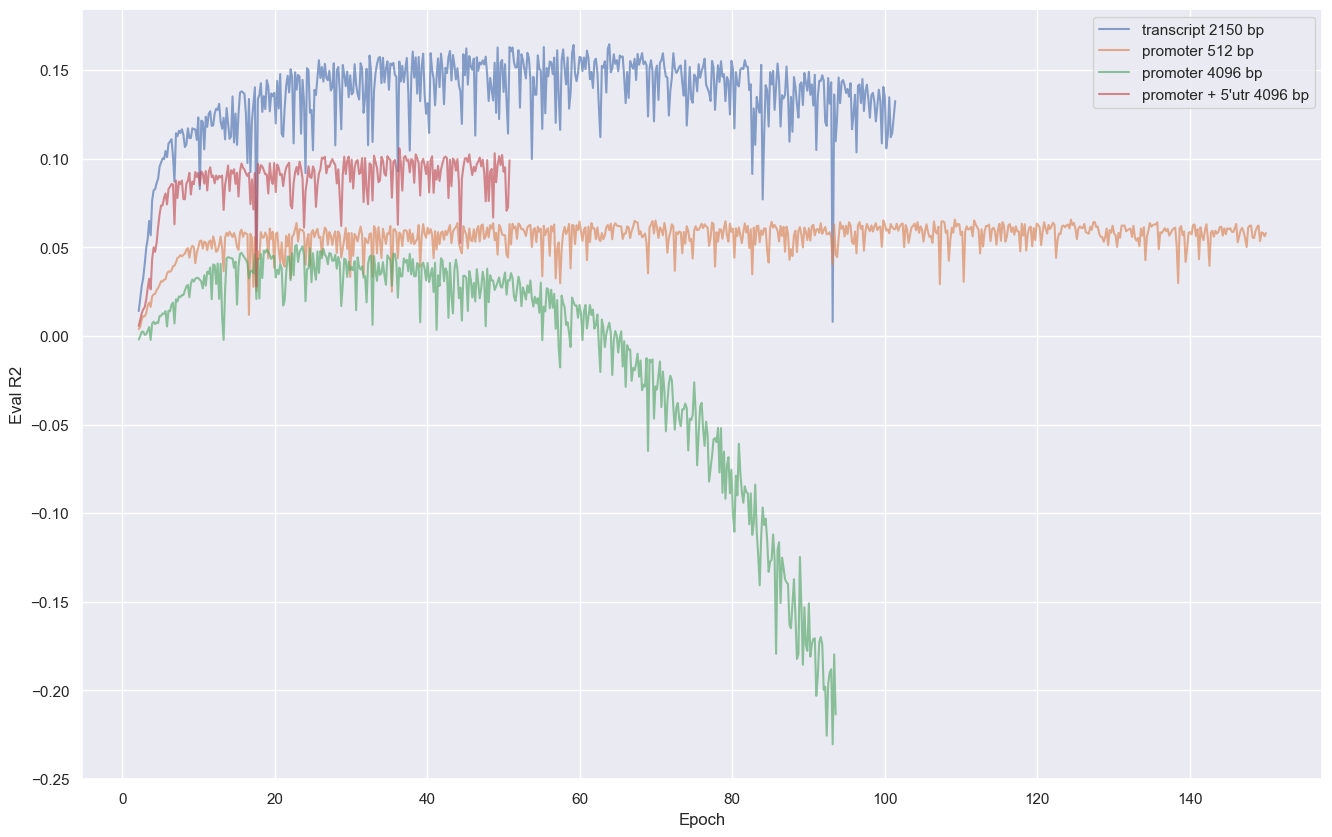

In [39]:
# Plot baseline

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['global-mean', 'rnn', '-3-', '00'],
		drop_only = []
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  2 * STEPS_PER_EPOCH),
	steps_max       = int(150 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	style           = 'sequence',
	filename        = os.path.join(DATA_DIR, 'bert-baseline-sequence'),
	bbox_inches     = 'tight'
)

## 5.3 K-Mer

In [40]:
# Display the performance of the model for the different kmers

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'def']
x = x[x['Filter']   == 2]
x = x[x['Feature']  != 0]
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']
x = x.drop(columns = ['Layer', 'Feature'])
x = x.reset_index(drop = True)

x

,Target,Pooler,Type,KMer,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,first,def,3,2,promoter 512 bp,106.2,250.0,0.33506
1,global-mean,first,def,4,2,promoter 512 bp,92.2,250.0,0.31528
2,global-mean,first,def,5,2,promoter 512 bp,105.7,250.0,0.29227
3,global-mean,first,def,6,2,promoter 512 bp,172.7,250.0,0.28333


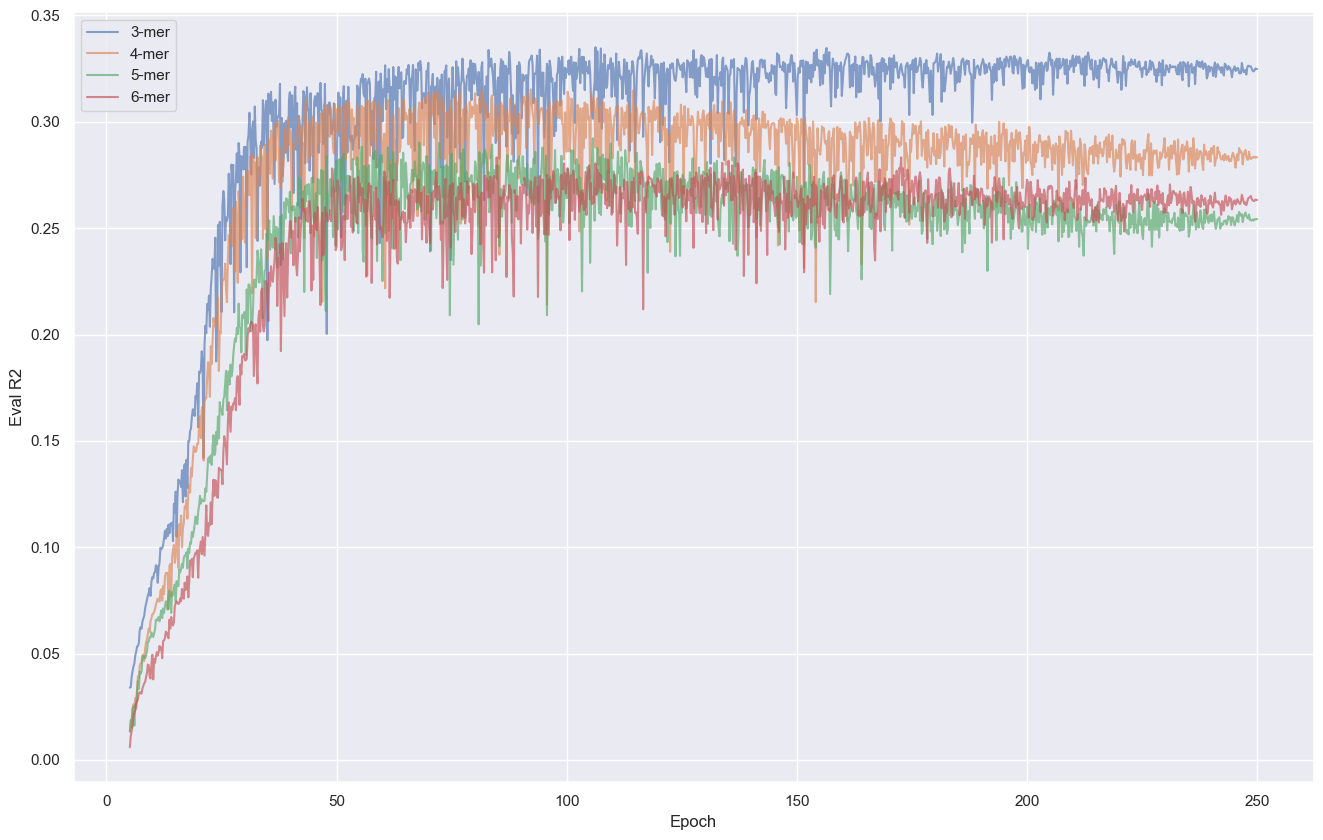

In [41]:
# Plot kmer

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['global-mean', 'f2', 'v1', 'def'],
		drop_only = ['00']
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	style           = 'kmer',
	filename        = os.path.join(DATA_DIR, 'bert-kmer'),
	bbox_inches     = 'tight'
)

## 5.4 Filter

In [42]:
# Display the performance of the model for the different filters

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'def']
x = x[x['KMer']     == 3]
x = x[x['Feature']  != 0]
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']
x = x.drop(columns = ['Layer', 'Feature'])
x = x.reset_index(drop = True)

x

,Target,Pooler,Type,KMer,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,first,def,3,2,promoter 512 bp,106.2,250.0,0.33506
1,global-mean,first,def,3,4,promoter 512 bp,139.8,250.0,0.33150
2,global-mean,first,def,3,5,promoter 512 bp,31.4,125.4,0.31555
3,global-mean,first,def,3,1,promoter 512 bp,120.7,236.7,0.30900
4,global-mean,first,def,3,3,promoter 512 bp,102.1,180.7,0.26337
5,global-mean,first,def,3,6,promoter 512 bp,95.1,139.1,0.25098


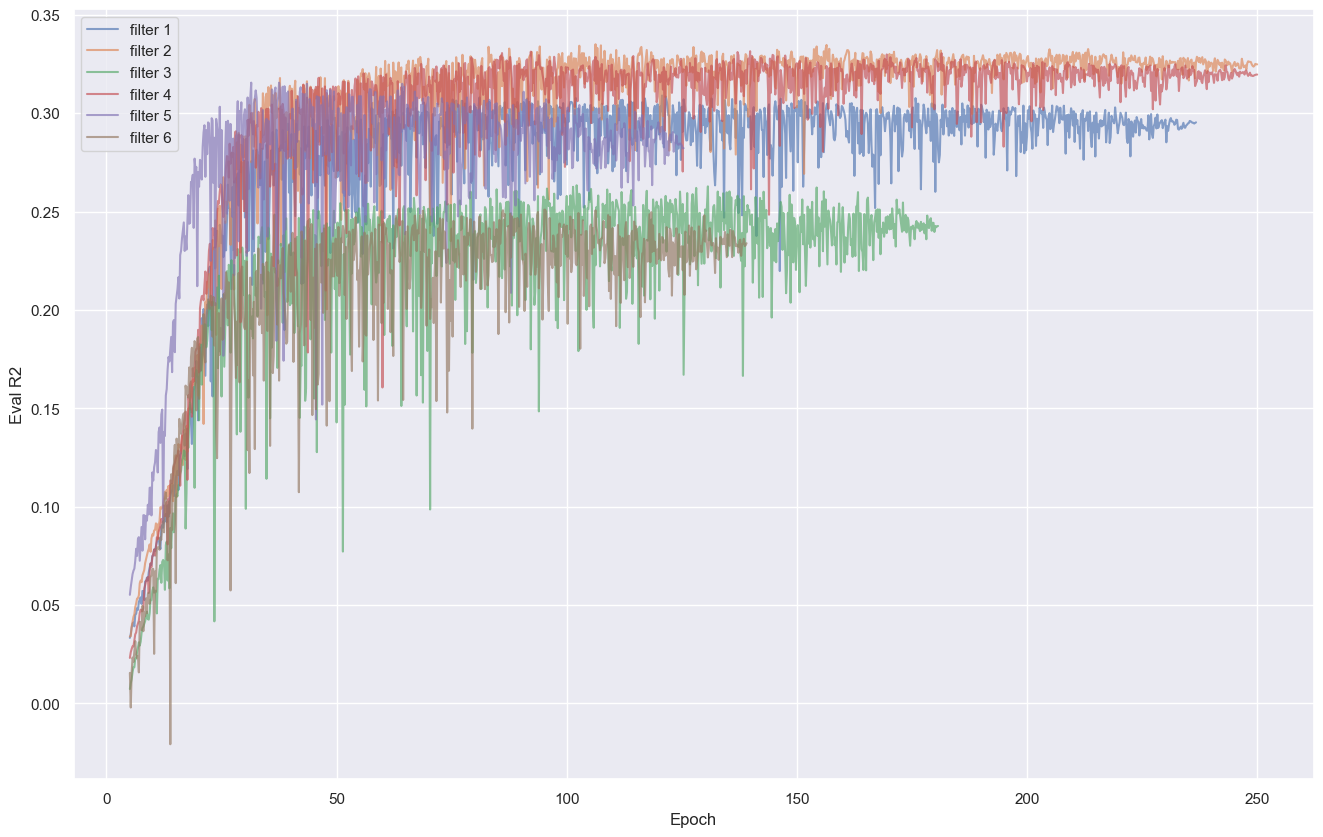

In [43]:
# Plot filter

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['global-mean', '-3-', 'v1', 'def'],
		drop_only = ['00']
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	style           = 'filter',
	filename        = os.path.join(DATA_DIR, 'bert-filter'),
	bbox_inches     = 'tight'
)

## 5.5 Pooler

In [44]:
# Display the performance of the model for the different poolers

x = report
x = x[x['KMer']     == 3]
x = x[x['Filter']   == 2]
x = x[x['Feature']  != 0]
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']
x = x.drop(columns = ['Layer', 'Feature'])
x = x.reset_index(drop = True)

x

,Target,Pooler,Type,KMer,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,mean,cat,3,2,promoter 512 bp,114.3,250.0,0.34600
1,global-mean,first,rnn,3,2,promoter 512 bp,111.7,250.0,0.34468
2,global-mean,mean,rnn,3,2,promoter 512 bp,70.7,250.0,0.34117
3,global-mean,first,cat,3,2,promoter 512 bp,89.1,250.0,0.34046
4,global-mean,first,def,3,2,promoter 512 bp,106.2,250.0,0.33506
5,global-mean,mean,def,3,2,promoter 512 bp,146.1,250.0,0.33276


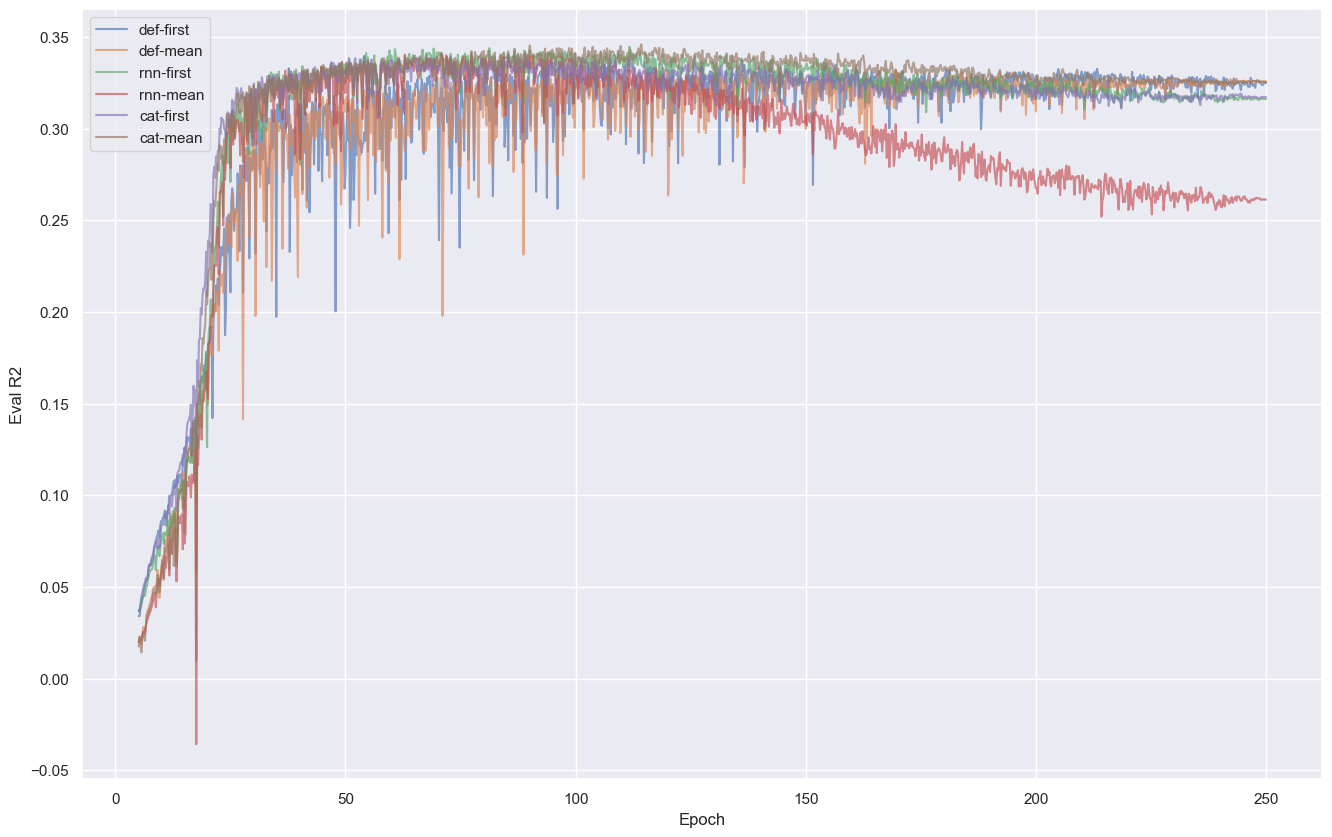

In [45]:
# Plot architecture

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['global-mean', '-3-', 'f2', 'po0512'],
		drop_only = ['00']
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	style           = 'pooler-architecture',
	filename        = os.path.join(DATA_DIR, 'bert-pooler'),
	bbox_inches     = 'tight'
)

## 5.6 Sequence

In [46]:
# Display the performance of the model for the different input sequences

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'rnn']
x = x[x['KMer']     == 3]
x = x[x['Filter']   == 2]
x = x[x['Feature']  != 0]
x = x[x['Target']   == 'global-mean']
x = x.drop(columns = ['Layer', 'Feature'])
x = x.reset_index(drop = True)

x

,Target,Pooler,Type,KMer,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,first,rnn,3,2,promoter 512 bp,111.7,250.0,0.34468
1,global-mean,first,rnn,3,2,promoter + 5'utr 4096 bp,50.8,123.8,0.34270
2,global-mean,first,rnn,3,2,transcript 2150 bp,63.7,243.8,0.33994
3,global-mean,first,rnn,3,2,promoter 4096 bp,37.7,119.7,0.32171


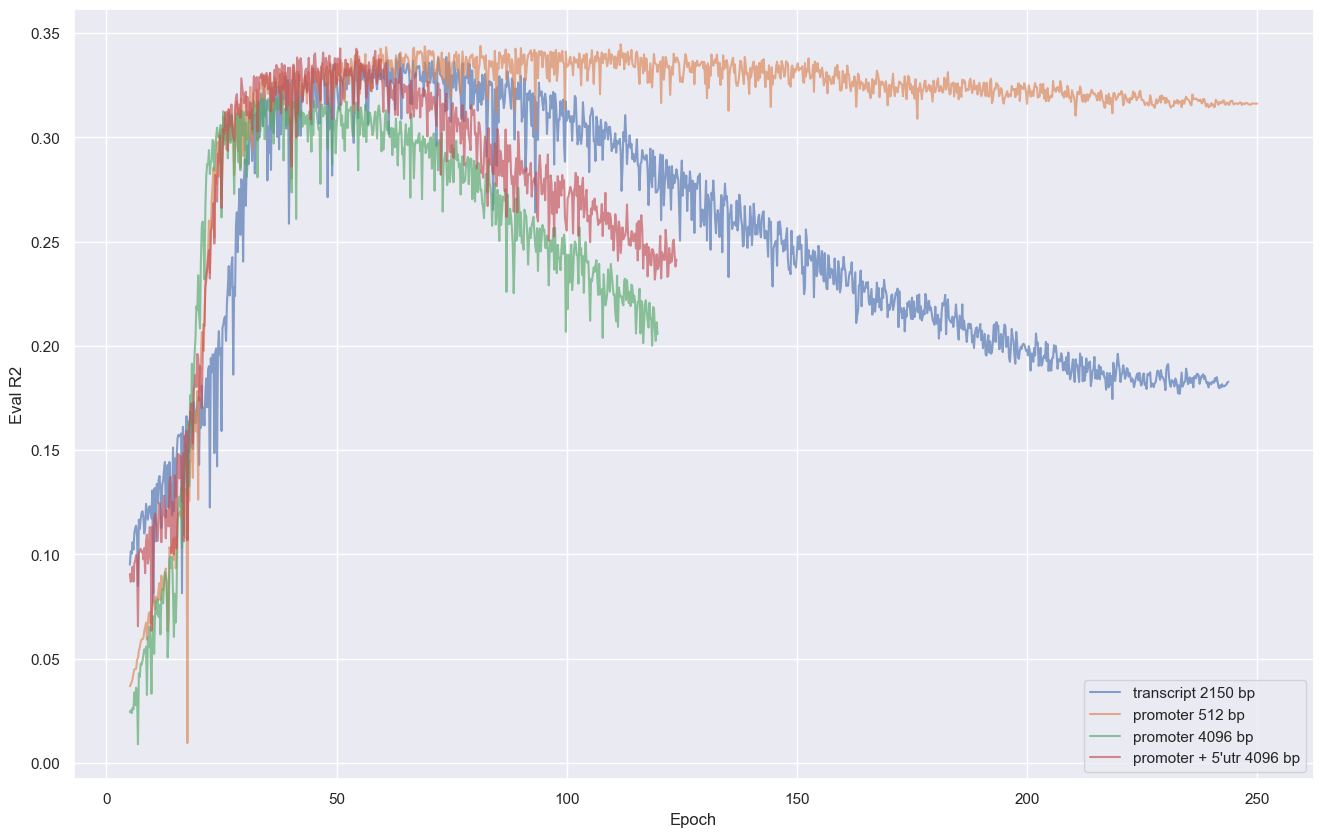

In [47]:
# Plot sequence

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['global-mean', '-3-', 'f2', 'v1', 'rnn'],
		drop_only = ['00']
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	style           = 'sequence',
	filename        = os.path.join(DATA_DIR, 'bert-sequence'),
	bbox_inches     = 'tight'
)

## 5.7 Final

In [48]:
# Display the performance of the model

x = report
x = x[x['KMer']     == 3]
x = x[x['Feature']  != 0]
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'rnn']
x = x[x['Target']   != 'tissue-mean-seedling']
x = x.drop(columns = ['Layer', 'Feature'])
x = x.reset_index(drop = True)

x.head(n = 10)

,Target,Pooler,Type,KMer,Filter,Sequence,Epoch,Epochs,R2
0,global-mean,first,rnn,3,2,promoter 512 bp,111.7,250.0,0.34468
1,tissue-mean-explode,first,rnn,3,2,promoter 512 bp,29.5,60.0,0.34403
2,global-mean,first,rnn,3,2,promoter + 5'utr 4096 bp,50.8,123.8,0.34270
3,global-mean,first,rnn,3,2,transcript 2150 bp,63.7,243.8,0.33994
4,group-mean,first,rnn,3,2,promoter 512 bp,102.1,250.0,0.33869
5,tissue-mean,first,rnn,3,2,promoter 512 bp,80.7,250.0,0.33857
6,group-mean,first,rnn,3,2,transcript 2150 bp,59.6,240.8,0.33332
7,tissue-mean,first,rnn,3,2,transcript 2150 bp,67.4,242.8,0.33255
8,group-mean,first,rnn,3,2,promoter + 5'utr 4096 bp,54.5,123.0,0.33030
9,tissue-mean-explode,first,rnn,3,2,transcript 2150 bp,14.3,15.2,0.32801


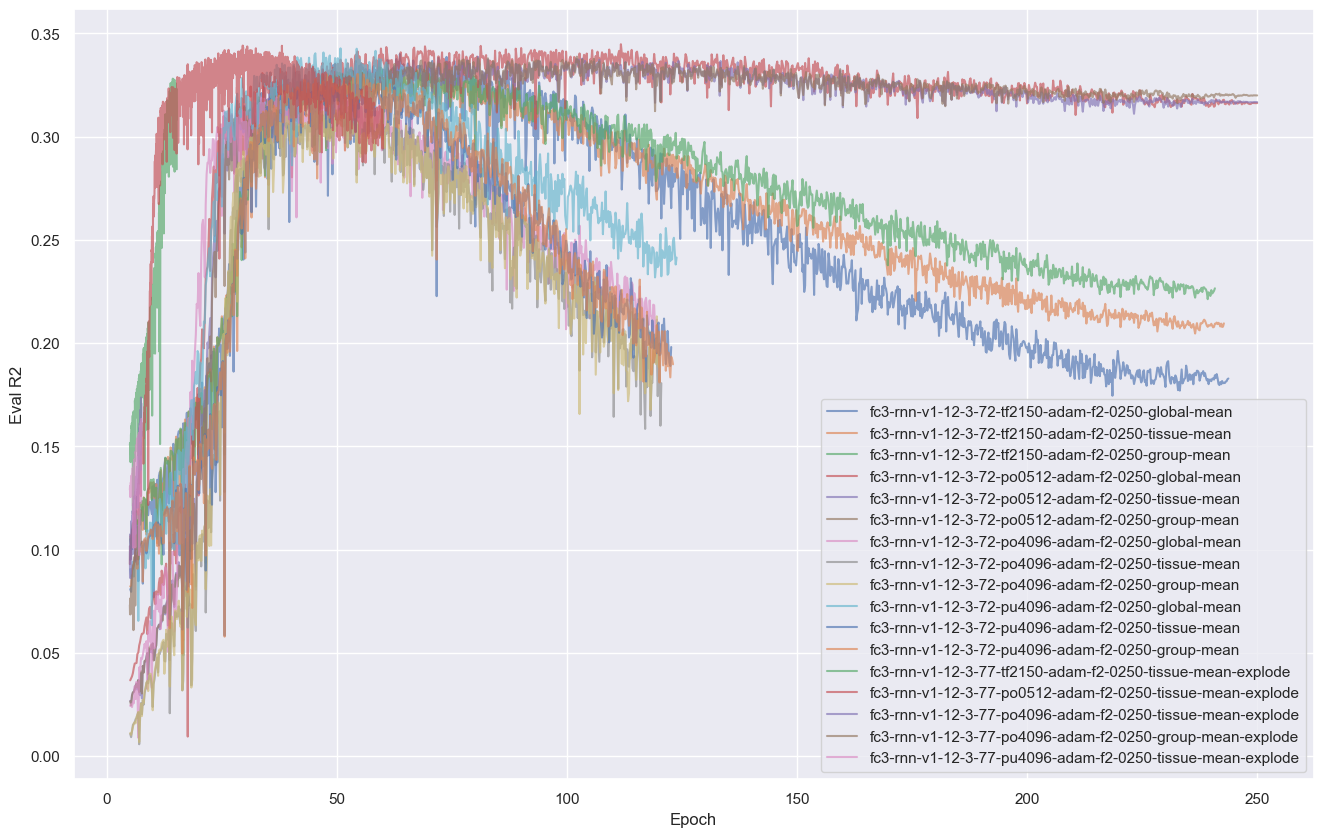

In [49]:
# Plot final

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['rnn', 'v1', '-3-', 'f2'],
		drop_only = ['00', 'seedling']
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	style           = 'none',
	filename        = os.path.join(DATA_DIR, 'bert-final'),
	bbox_inches     = 'tight'
)